In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORD = set(stopwords.words('english'))


[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re  

In [3]:
data = pd.read_csv('./Dataset/amazon_alexa.tsv', delimiter = '\t', quoting = 3)
data.shape

(3150, 5)

In [4]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [5]:
print(f"Features names : {data.columns.values}")

Features names : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [6]:
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [7]:
data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [8]:
data.dropna(inplace=True)

In [9]:
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [10]:
data['length'] = data['verified_reviews'].apply(len)
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [11]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

In [12]:
print(f"Rating value count : \n {data['rating'].value_counts()}")

Rating value count : 
 rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


CONSIDERING ONLY POSITIVE AND NEGATIVE REVIEWS

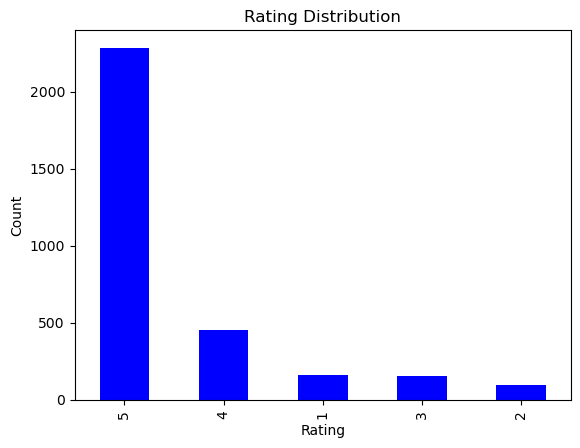

In [13]:
data['rating'].value_counts().plot.bar(color='blue')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

PIE CHART

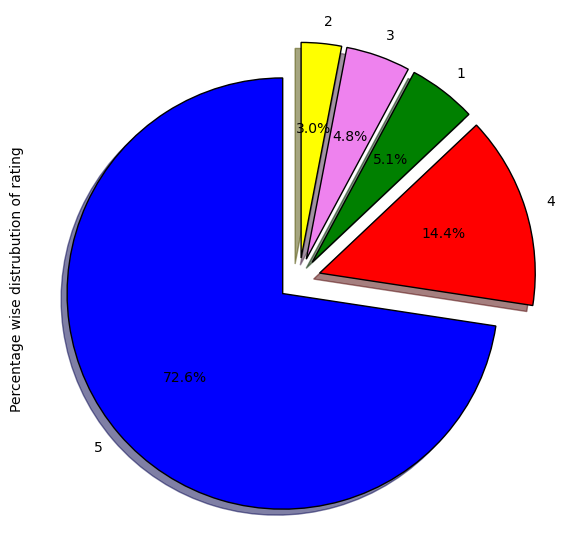

In [14]:
fig = plt.figure(figsize=(7,7))
colors = ('blue','red','green','violet','yellow')
wp = {'linewidth':1,"edgecolor":'black'}
tags = data['rating'].value_counts()/data.shape[0]
explode=(0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

In [15]:
print(f"Feedback value count: \n{data['feedback'].value_counts()}")

Feedback value count: 
feedback
1    2893
0     256
Name: count, dtype: int64


In [16]:
review_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


In [17]:
review_2 = data[data['feedback'] == 0].iloc[1]['verified_reviews']
print(review_2)

Sound is terrible if u want good music too get a bose


1 means that the review is good
0 means that the review is bad.

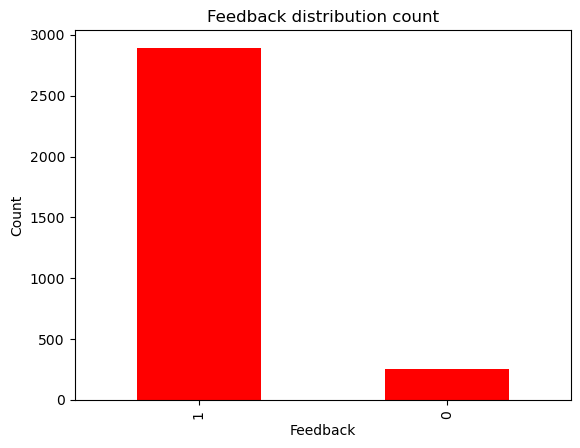

In [18]:
data['feedback'].value_counts().plot.bar(color = 'red')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [19]:
data[data['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

Analyzing Variation Column

In [20]:
print(f"Variation value Count: \n {data['variation'].value_counts()}")

Variation value Count: 
 variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


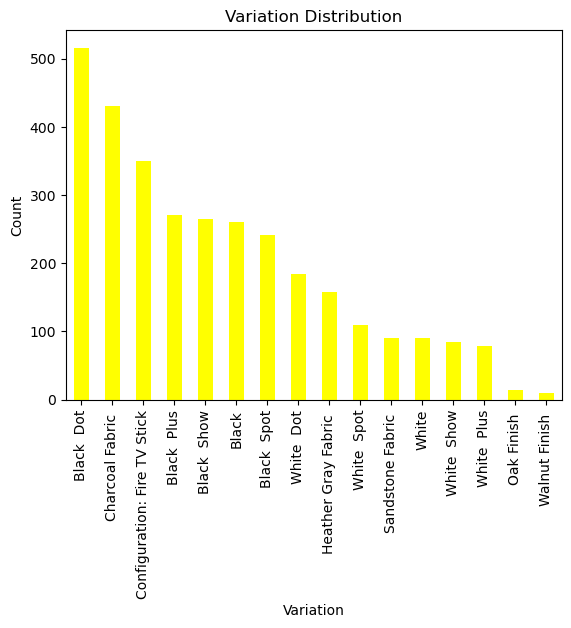

In [21]:
data['variation'].value_counts().plot.bar(color='yellow')
plt.title('Variation Distribution')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [22]:
print(f"Variation value count - percentage distribution: \n{round(data['variation'].value_counts()/data.shape[0]*100,2)}")

Variation value count - percentage distribution: 
variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64


In [23]:
data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

In [24]:
data['length'].describe()

count    3149.000000
mean      132.714513
std       182.541531
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

[Text(0.5, 1.0, 'Distribution of length of Reviews')]

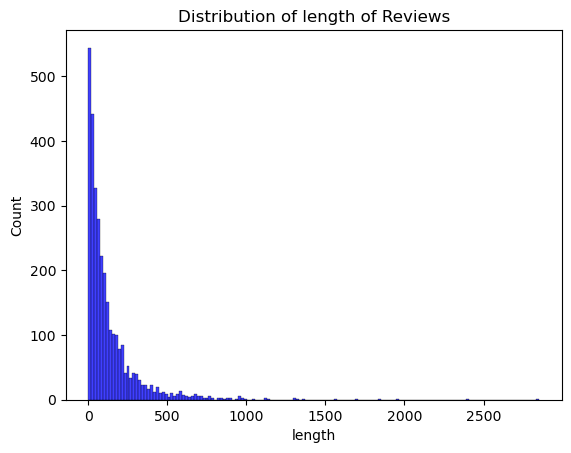

In [25]:
sns.histplot(data['length'],color='blue').set(title='Distribution of length of Reviews')

In [26]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data['verified_reviews'])

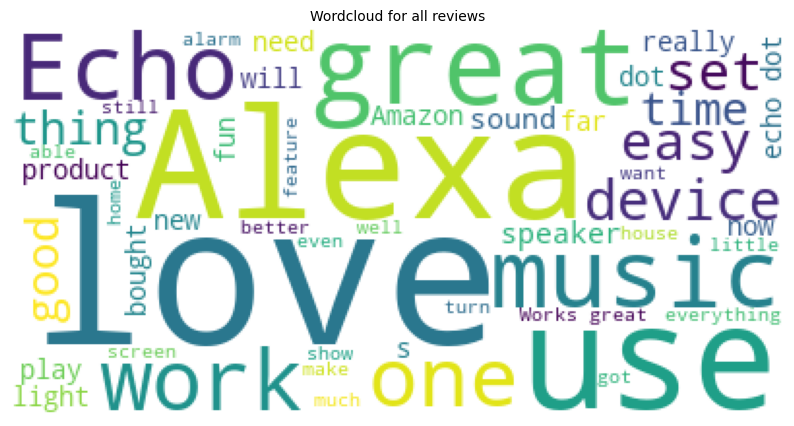

In [27]:
reviews = " ".join([review for review in data['verified_reviews']])

#Initialize wordcloud object

wc = WordCloud(background_color='white', max_words=50)

plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize = 10)
plt.axis('off')
plt.show()

In [28]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

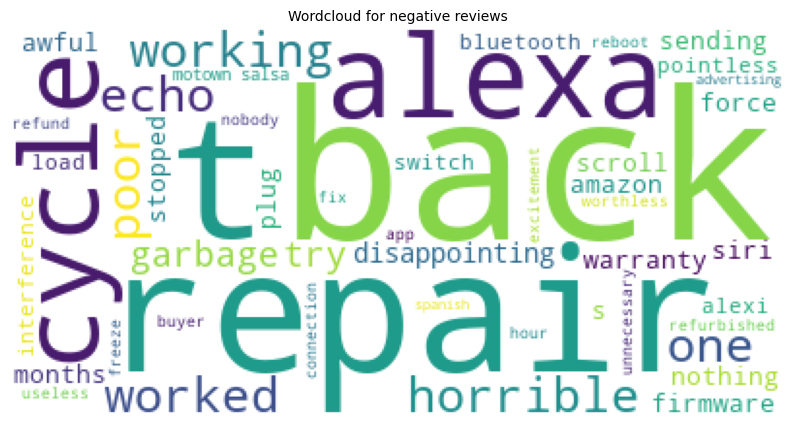

In [29]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

Preprocessing and Modelling

In [30]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
    review = re.sub('[^a-zA-Z]',' ',data.iloc[i]['verified_reviews'])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if not word in STOPWORD]
    review = ' '.join(review)
    corpus.append(review)

In [31]:
cv = CountVectorizer(max_features = 2500)
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [32]:
pickle.dump(cv, open('Models/countVectorizer.pkl','wb'))

In [33]:
print(f"X shape : {X.shape}")
print(f"y shape : {y.shape}")

X shape : (3149, 2500)
y shape : (3149,)


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2204, 2500)
y train: (2204,)
X test: (945, 2500)
y test: (945,)


In [35]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 12
X test max value: 10


In [36]:
scaler = MinMaxScaler()
X_train_scal = scaler.fit_transform(X_train)
X_test_scal = scaler.fit_transform(X_test)

In [37]:
pickle.dump(scaler, open('./Models/scaler.pkl','wb'))

Random Forest Classifier

In [38]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scal, y_train)

RandomForestClassifier()

In [39]:
print("Training Accuracy :", model_rf.score(X_train_scal, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scal, y_test))

Training Accuracy : 0.9945553539019963
Testing Accuracy : 0.9470899470899471


In [40]:
y_preds = model_rf.predict(X_test_scal)

In [41]:
cm = confusion_matrix(y_test, y_preds)

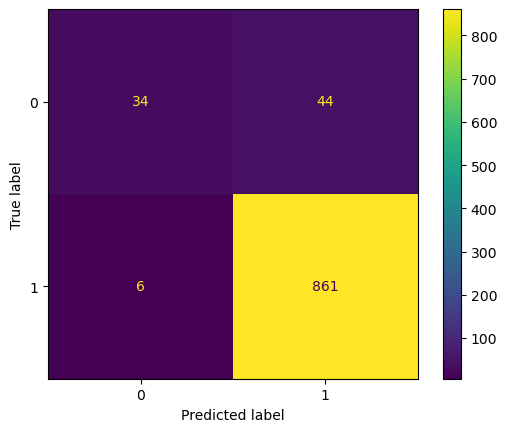

In [42]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = model_rf.classes_)
cm_display.plot()
plt.show()

K FOLD CROSS VALIDATION

In [43]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scal, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9328506787330315
Standard Variance : 0.007251144566917695


In [44]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [45]:
cv_object = StratifiedKFold(n_splits=2)
grid_search = GridSearchCV(estimator=model_rf, param_grid=params, cv = cv_object, verbose = 0, return_train_score=True)

In [46]:
grid_search.fit(X_train_scal, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [47]:
print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 80, 'min_samples_split': 8, 'n_estimators': 100}


In [48]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 96.71619782214155
Cross validation mean accuracy on test set : 92.20167876588022
Accuracy score for test set : 0.9470899470899471


XGBOOST

In [49]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scal, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [51]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_xgb.score(X_train_scal, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scal, y_test))

Training Accuracy : 0.971415607985481
Testing Accuracy : 0.9343915343915344


In [52]:
y_preds = model_xgb.predict(X_test)

In [53]:
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 31  47]
 [ 13 854]]


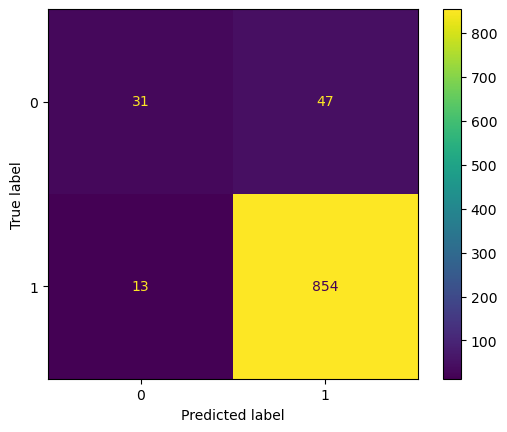

In [54]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [55]:
pickle.dump(model_xgb, open('Models/model_xgb.pkl', 'wb'))

DECISION TREE CLASSIFIER

In [58]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scal, y_train)

DecisionTreeClassifier()

In [60]:
print("Training Accuracy :", model_dt.score(X_train_scal, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scal, y_test))

Training Accuracy : 0.9945553539019963
Testing Accuracy : 0.9142857142857143


In [61]:
y_preds = model_dt.predict(X_test)


In [62]:
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 41  37]
 [ 75 792]]


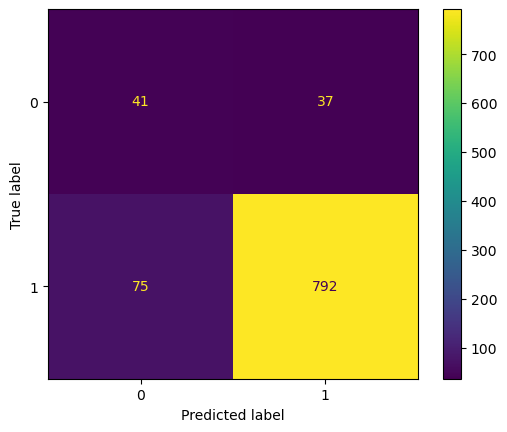

In [63]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()